In [87]:
# from llama_index.core import (
#     VectorStoreIndex,
#     SimpleDirectoryReader,
#     Settings,
#     ServiceContext,
#     StorageContext,
#     load_index_from_storage,
# )
# from llama_index.core.embeddings.utils import resolve_embed_model
# from llama_index.llms.ollama import Ollama
# from llama_index.core import VectorStoreIndex, get_response_synthesizer
# from llama_index.core.retrievers import VectorIndexRetriever
# from llama_index.core.query_engine import RetrieverQueryEngine
# from llama_index.core.postprocessor import SimilarityPostprocessor
# from llama_index.core import Settings
# from llama_index.core.node_parser.text.sentence import SentenceSplitter

# from transformers import AutoTokenizer

import pandas as pd
pd.set_option('display.max_colwidth', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from llama_cpp import Llama
from llama_cpp import LlamaGrammar

from pathlib import Path
import random
import json
import shutil

In [88]:
GENERATE_METHODS_DIR = Path('data/docs/manual')
METHODS_DIR = Path('data/docs/methods')
PROMPT_SEEDS_DIR = Path('data/prompts/generation/components')
PROMPT_COMPONENTS_DIR = Path('data/prompts/generation/components')
VAL_PROMPT_COMPONENTS_DIR = Path('data/prompts/validation/components')
GEN_PROMPTS_DIR = Path('data/prompts/generation/output')
VAL_PROMPTS_DIR = Path('data/prompts/validation/output')
PERSIST_DIR = Path("data/persist_dir")
OUTPUT_DIR = Path("output/")
MODELS_PATH = Path('models/')
DATA_DIR = Path('data/')

# index generation & loading

In [34]:
# default tokenizer is for gpt-3.5
# llama_index.core.global_tokenizer

In [35]:
# documents = SimpleDirectoryReader(METHODS_DIR).load_data()

# embed_tokenizer = AutoTokenizer.from_pretrained(
#     "BAAI/bge-base-en-v1.5"
# )
# Settings.text_splitter = SentenceSplitter(chunk_size=768, tokenizer=embed_tokenizer)

# Settings.embed_model = resolve_embed_model("local:BAAI/bge-base-en-v1.5")

# index = VectorStoreIndex.from_documents(
#     documents, show_progress=True
# )

# index.storage_context.persist(persist_dir=PERSIST_DIR)

In [5]:
Settings.embed_model = resolve_embed_model("local:BAAI/bge-base-en-v1.5")

# rebuild storage context
storage_context = StorageContext.from_defaults(persist_dir=PERSIST_DIR)

# load index
index = load_index_from_storage(storage_context, show_progress=True)

In [6]:
retriever = VectorIndexRetriever(
    index=index,
    similarity_top_k=3,
)

# check index

In [7]:
# Assuming you have an instance of TreeIndex named tree_index
ref_doc_info = index.ref_doc_info

# Now you can iterate over the ref_doc_info to view each node's details
with open('temp/index.txt', 'w') as f:
    for node_id, node_info in ref_doc_info.items():
        f.write(f"Node ID: {node_id}\n")
        f.write(f"Node Info: {node_info}\n")

In [8]:
# r = retriever.retrieve('Get status of a cover.')
# print(r)

# llm loading (skip)

In [9]:
# llm = Llama('models/mistral-7b-instruct-v0.2.Q6_K.gguf', n_ctx=4000, verbose=False, n_gpu_layers=25) # mistral-7b-instruct-v0.2.Q4_0.gguf mistral-7b-instruct-v0.2.Q4_K_M.gguf

In [10]:
# prompt = """
# Command: Please, close the living room blinds slowly for 20 seconds.

# What is the function user want to call in smart home?
# """
# llm.create_chat_completion(messages=[{'role': 'user', 'content': prompt}], max_tokens=100)

In [11]:
# !nvidia-smi

# prompt preparation

In [12]:
def get_base_prompt_variables():
    json_scheme_prompt = {
        "method": {
            "type": "string"
        },
        "params": {
            "type": "object"
        }
    }

    example_1_json = {
      "method":"Cover.Open",
      "params":
      {
        "id":2
      }
    }

    example_2_json = {
      "method":"Light.Set",
      "params":
      {
        "id":5,
        "on":True,
        "toggle_after":30,
      }
    }

    with open(VAL_PROMPT_COMPONENTS_DIR / 'instruction.md') as f:
      instruction = f.read()

    variables = {
    "instruction": instruction,
    "json_scheme": "The output JSON should follow the next scheme: " + json.dumps(json_scheme_prompt),
    "example_1": """Devices: Entryway Smoke 2 id=15, Attic Cover 1 id=2, Kitchen Temperature 4 id=10
Methods:
API method 1:
Method name: Cover.Open
Method description: 
Properties:
{"id": {"type": "number", "description": "The numeric ID of the Cover component instance"}, "duration": {"type": "number", "description": "If duration is not provided, Cover will fully open, unless it times out because of maxtime_open first. If duration (seconds) is provided, Cover will move in the open direction for the specified time. duration must be in the range [0.1..maxtime_open]Optional"}}
Response:
null on success; error if the request can not be executed or failed

Command: Open the Attic Cover 1.
JSON: """ + json.dumps(example_1_json),

    "example_2": """Devices: Garage Cover 5 id=100, Study room Light 4 id=5, Bedroom Switch 1 id=7, Bedroom Smoke 3 id=120, Greenhouse Temperature 3 id=16, Living room Humidity 2 id=38
Methods: 
API method 1:
Method name: Light.Set
Method description: This method sets the output and brightness level of the Light component. It can be used to trigger webhooks. More information about the events triggering webhooks available for this component can be found below.
Request
Parameters:
{"id": {"type": "number", "description": "Id of the Light component instance. Required"}, "on": {"type": "boolean", "description": "True for light on, false otherwise. Optional"}, "brightness": {"type": "number", "description": "Brightness level Optional"}, "transition_duration": {"type": "number", "description": "Transition time in seconds - time between change from current brightness level to desired brightness level in request Optional"}, "toggle_after": {"type": "number", "description": "Optional flip-back timer in seconds. Optional"}}

Command: Turn on Study room Light 4. And automatically turn it off after half a minute.
JSON: """ + json.dumps(example_2_json),
    }

    return variables

In [13]:
def get_base_prompt():
    base_prompt_template = """
{instruction}
{json_scheme}

{example_1}

{example_2}
    """

    variables = get_base_prompt_variables()

    base_prompt = base_prompt_template.format(**variables)

    return base_prompt

def get_user_prompt_template():
    user_prompt_template = """Devices: {env}
Methods:
{methods_description}

Command: {user_cmd}
JSON:
    """

    return user_prompt_template

print(get_base_prompt())


You are a helpful AI Assistant that controls devices in a house. For a given user command create a corresponding JSON object. In any case you mustn't include JSON fields that equal null because null will break the smart home system. Don't include field instead of setting field to null. Output must be strictly in JSON format.
The output JSON should follow the next scheme: {"method": {"type": "string"}, "params": {"type": "object"}}

Devices: Entryway Smoke 2 id=15, Attic Cover 1 id=2, Kitchen Temperature 4 id=10
Methods:
API method 1:
Method name: Cover.Open
Method description: 
Properties:
{"id": {"type": "number", "description": "The numeric ID of the Cover component instance"}, "duration": {"type": "number", "description": "If duration is not provided, Cover will fully open, unless it times out because of maxtime_open first. If duration (seconds) is provided, Cover will move in the open direction for the specified time. duration must be in the range [0.1..maxtime_open]Optional"}}
Re

# logging

In [14]:
# import logging
# import sys

# logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
# logger = logging.getLogger()
# logger.addHandler(logging.StreamHandler(stream=sys.stdout))

In [15]:
# logger.disabled = True

# predict functions

In [3]:
def predict_prompt(llm, prompt, grammar=None):
    response = llm.create_chat_completion(
        messages=[
            {'role': 'user', 'content': prompt}
        ],
        grammar=grammar
    )

    response_text = response['choices'][0]['message']['content']
    response_text = response_text.replace('\_', '_')

    try:
        json_cmd = json.dumps(json.loads(response_text))
    except Exception as e:
        print(e)
        print(response_text)
        return ""

    return json_cmd

def get_methods_description(retrieved_nodes):
    methods_names = []
    methods_description = ''
    for k, node in enumerate(retrieved_nodes):
        methods_description += f'API method {k}:\n{node.text}\n\n'
        method_name = node.metadata['file_name'].replace('.md', '')
        methods_names.append(method_name)

    methods_names = ','.join(methods_names)
    methods_description = methods_description.strip('\n')

    return methods_names, methods_description

def predict(llm, df, run_name, num_nodes=3, selected_devices=None, selected_ids=None, limit_rows=None, verbose=False):
    output_path = OUTPUT_DIR / run_name / 'output.csv'

    with open('data/grammars/json.gbnf') as f:
        grammar_str = f.read()
    llama_grammar = LlamaGrammar.from_string(grammar_str, verbose=False)

    if selected_devices:
        df = df[df['device'].isin(selected_devices)].sort_index()
    
    if selected_ids:
        df = df[df['id'].isin(selected_ids)]

    if limit_rows:
        df = df.iloc[:limit_rows]

    output_df = pd.DataFrame(columns=['id', 'device', 'user_cmd', 'mtd', 'json_cmd'])
    for i, row in df.iterrows():
        print(i)
        user_cmd = row['user_cmd']

        env = row['env']

        retrieval_prompt = "Represent this sentence for searching relevant passages: " + user_cmd
        retrieved_nodes = retriever.retrieve(retrieval_prompt)
        
        completed = False
        while (not completed) and (num_nodes > 0):
            try:
                methods_names, methods_description = get_methods_description(retrieved_nodes[:num_nodes])

                user_prompt = get_user_prompt_template().format(**{'env': env, 
                                                            'methods_description': methods_description, 
                                                            'user_cmd': user_cmd})
                prompt = get_base_prompt() + '\n\n' + user_prompt

                json_cmd = predict_prompt(llm, prompt, llama_grammar)

                completed = True
            except Exception as e:
                print(e)

                num_nodes -= 1
        
        if verbose:
            print(f'{prompt}\n')
            print('<<<------------------------------------------>>>\n\n')
        
        if json_cmd == "":
            continue

        output_series = pd.Series({'id': row['id'], 'mtd': methods_names, 'json_cmd': json_cmd})
        output_df.loc[len(output_df)] = output_series

        if i == df.index[0]:
            header = True
            mode = 'w'
        else:
            header = False
            mode = 'a'
        output_df.iloc[[len(output_df)-1]].to_csv(output_path, index=False, header=header, mode=mode)
    
    return output_df

# evaluation functions

In [4]:
# necessary properties are absent
# returns True if check failed
def check_necessary_parameters(gt_json, pred_json):
    for key, val in gt_json.items():
        if key not in pred_json:
            return True
        if type(val) == dict:
            if check_necessary_parameters(val, pred_json[key]):
                return True
    return False

# some additional from method doc (with or without necessary)
def check_additional_parameters(gt_json, pred_json, json_scheme):
    for key, val in pred_json.items():
        if key not in json_scheme:
                continue
        if key not in gt_json:
            return True
        if type(val) == dict:
            try:
                if check_additional_parameters(val, gt_json[key], json_scheme[key]['properties']):
                    return True
            except Exception as e:
                print(e)
                print(key, pred_json, gt_json, json_scheme, sep='\n')
    return False

# hallucinated properties that aren’t described in method doc
def check_hallucinated_parameters(pred_json, json_scheme):
    for key, val in pred_json.items():
        if key not in json_scheme:
            return True
        if type(val) == dict:
            if check_hallucinated_parameters(val, json_scheme[key]['properties']):
                return True
    return False

# incorrect value of parameter from prediction
def check_correctness_parameters(gt_json, pred_json):
    for key, val in pred_json.items():
        if key not in gt_json:
                continue
        if type(val) == dict:
            if check_correctness_parameters(val, gt_json[key]):
                return True
        elif gt_json[key] != val:
            return True
    return False

def check_correctness_json(gt_json, pred_json):
    return gt_json == pred_json

def compare_gt_pred(output_df, gt_df):
    merged_df = gt_df.merge(output_df, how='inner', on='id', suffixes=("_gt", "_pred"))
    json_schemes_df = pd.read_csv(METHODS_DIR.parent / 'methods_json.csv')
    compared_df = pd.DataFrame(columns=['id', 'device', 'user_cmd', 'gt_mtd', 'pred_mtd', 'gt_json_cmd', 'pred_json_cmd',
                                               'retriever_cor', 'json_cor', 'add', 'hall', 'absent', 'incor'])
    for _, row in merged_df.iterrows():
        methods_names_pred = row['mtd_pred'].split(',')
        try:
            gt_json = json.loads(row['json_cmd_gt'])
            pred_json = json.loads(row['json_cmd_pred'])
        except Exception as ex:
            print(ex)
            print(row['id'])
            print(row['json_cmd_gt'])
            print(row['json_cmd_pred'])
            continue
        method_name = pred_json['method']
        method_df = json_schemes_df[json_schemes_df['method'] == method_name]
        if method_df.shape[0] == 0:
            json_scheme = None
        else:
            json_scheme = json.loads(method_df.iloc[0]['json'])
        compared_dict = {'id': row['id'], 'device': row['device_gt'],
            'user_cmd': row['user_cmd_gt'], 'gt_mtd': row['mtd_gt'],
            'pred_mtd': row['mtd_pred'], 'gt_json_cmd': row['json_cmd_gt'], 'pred_json_cmd': row['json_cmd_pred']}
        
        compared_dict['retriever_cor'] = row['mtd_gt'] in methods_names_pred
        compared_dict['json_cor'] = check_correctness_json(gt_json, pred_json)
        compared_dict['absent'] = check_necessary_parameters(gt_json, pred_json)
        compared_dict['incor'] = check_correctness_parameters(gt_json, pred_json)
        if json_scheme:
            compared_dict['add'] = check_additional_parameters(gt_json, pred_json, json_scheme)
            compared_dict['hall'] = check_hallucinated_parameters(gt_json, json_scheme)
        else:
            compared_dict['add'] = False
            compared_dict['hall'] = False

        compared_df.loc[len(compared_df)] = pd.Series(compared_dict)
    return compared_df

In [5]:
def evaluate(gt_df, output_df, run_name, settings, save_intermediate=False, verbose=False):
    compared_df = compare_gt_pred(output_df, gt_df)
    if save_intermediate:
        compared_df.to_csv(OUTPUT_DIR / run_name / 'compared.csv', index=False)
    if verbose:
        print(len(gt_df))
        print(len(compared_df))

    results_df = pd.DataFrame(columns=['run_name', 'settings', 'method_acc', 'json_acc'])

    method_acc = compared_df[compared_df['retriever_cor'] == True].shape[0] / compared_df.shape[0]
    json_acc = compared_df[compared_df['json_cor'] == True].shape[0] / compared_df.shape[0]
    results_df.loc[0] = pd.Series({'run_name': run_name,
                                    'settings': json.dumps(settings),
                                    'method_acc': method_acc,
                                    'json_acc': json_acc})
    results_df.to_csv(OUTPUT_DIR / 'results.csv', index=False, header=not (OUTPUT_DIR / 'results.csv').exists(), mode='a')

    fail_reasons_df = compared_df[compared_df['retriever_cor'] == True].copy(deep=True)
    fail_reasons_df = fail_reasons_df.loc[:, ['gt_mtd', 'retriever_cor', 'json_cor', 'add', 'hall', 'absent', 'incor']]
    fail_reasons_df.rename(columns={'gt_mtd': 'method'}, inplace=True)
    fail_reasons_df = fail_reasons_df.replace({True: 1, False: 0})
    fail_reasons_df = fail_reasons_df.groupby('method', as_index=False).sum()
    fail_reasons_df.insert(0, 'run_name', run_name)
    fail_reasons_df.to_csv(OUTPUT_DIR / 'fail_reasons.csv', index=False, header=not (OUTPUT_DIR / 'fail_reasons.csv').exists(), mode='a')

# plot functions

In [89]:
def plot_results(run_names):
    df = pd.read_csv(OUTPUT_DIR / 'results.csv')
    df = df[df['run_name'].isin(run_names)]
    fig, ax = plt.subplots(figsize=(8, 4))

    sns.barplot(data=df, x=df["run_name"], y="json_acc", ax=ax) # .apply(lambda x: '_'.join(x.split('_')[:2]))
    ax.set(xlabel='', ylabel='', title='')
    
    plt.xticks(rotation=45)
    fig.tight_layout()
    plt.show()

In [90]:
def plot_fail_reasons(run_names):
    df = pd.read_csv(OUTPUT_DIR / 'fail_reasons.csv')
    df = df[df['run_name'].isin(run_names)]
    df['method'] = df['method'].apply(lambda x: x.split('.')[1])
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
    ymax = 100

    order = df.groupby('method')['add'].sum().sort_values(ascending=False).index
    sns.barplot(data=df, x="method", y="add", hue="run_name", estimator='sum', order=order, ax=axs[0][0], errorbar=None)
    axs[0][0].set(xlabel='', ylabel='', title="Additional parameters", ylim=(0, ymax))
    axs[0][0].tick_params(axis='x', rotation=90)
    
    order = df.groupby('method')['hall'].sum().sort_values(ascending=False).index
    sns.barplot(data=df, x="method", y="hall", hue="run_name", estimator='sum', order=order, ax=axs[0][1], errorbar=None)
    axs[0][1].set(xlabel='', ylabel='', title="Hallucinated parameters", ylim=(0, ymax))
    axs[0][1].tick_params(axis='x', rotation=90)

    order = df.groupby('method')['absent'].sum().sort_values(ascending=False).index
    sns.barplot(data=df, x="method", y="absent", hue="run_name", estimator='sum', order=order, ax=axs[1][0], errorbar=None)
    axs[1][0].set(xlabel='', ylabel='', title="Absent parameters", ylim=(0, ymax))
    axs[1][0].tick_params(axis='x', rotation=90)

    order = df.groupby('method')['incor'].sum().sort_values(ascending=False).index
    sns.barplot(data=df, x="method", y="incor", hue="run_name", estimator='sum', order=order, ax=axs[1][1], errorbar=None)
    axs[1][1].set(xlabel='', ylabel='', title="Incorrect parameters", ylim=(0, ymax))
    axs[1][1].tick_params(axis='x', rotation=90)

    # axs[0][0].legend(labels=['gemma_2b', 'mistral_7b'])
    # axs[0][1].legend(labels=['gemma_2b', 'mistral_7b'])
    # axs[1][0].legend(labels=['gemma_2b', 'mistral_7b'])
    # axs[1][1].legend(labels=['gemma_2b', 'mistral_7b'])
    
    sns.despine()
    fig.tight_layout()
    plt.show()

# validate

In [21]:
MODELS = {
    'mistral-7b': 'mistral-7b-instruct-v0.2.Q5_K_M.gguf'
}
gt_df = pd.read_csv(DATA_DIR / 'datasets/merged/test_0.csv')
RUN_NAME = 'baseline'
NUM_EXAMPLES = 2
NUM_NODES = 3
MODEL_NAME = 'mistral-7b'
N_CTX = 4000
settings = {
    'llm': MODEL_NAME,
    'num_examples': NUM_EXAMPLES,
    'num_nodes': NUM_NODES,
    'num_examples': NUM_EXAMPLES,
    'n_ctx': N_CTX
}

In [22]:
(OUTPUT_DIR / RUN_NAME).mkdir(exist_ok=True)

with open(OUTPUT_DIR / RUN_NAME / "settings.json", 'w') as f:
    f.write(json.dumps(settings))
shutil.copy(VAL_PROMPT_COMPONENTS_DIR / 'instruction.md', OUTPUT_DIR / RUN_NAME)

if 'llm' in locals():
    del llm
    torch.cuda.empty_cache()
llm = Llama(str(MODELS_PATH / MODELS[MODEL_NAME]), n_ctx=N_CTX, verbose=False, n_gpu_layers=-1)

output_df = predict(llm, gt_df, RUN_NAME, num_nodes=NUM_NODES, verbose=False)

ggml_init_cublas: GGML_CUDA_FORCE_MMQ:   no
ggml_init_cublas: CUDA_USE_TENSOR_CORES: yes
ggml_init_cublas: found 1 CUDA devices:
  Device 0: NVIDIA GeForce RTX 2080, compute capability 7.5, VMM: yes


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
Requested tokens (4011) exceed context window of 4000
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263


In [ ]:
gt_df = pd.read_csv(DATA_DIR / 'datasets/merged/test_0.csv')
retr_df = pd.DataFrame(columns=['id', 'user_cmd', 'mtd_gt', 'mtd_pred', 'corr'])

for i, row in gt_df.iterrows():
    print(i)

    retrieval_prompt = "Represent this sentence for searching relevant passages: " + row['user_cmd']
    retrieved_nodes = retriever.retrieve(retrieval_prompt)

    methods_names = []
    for k, node in enumerate(retrieved_nodes):
        method_name = node.metadata['file_name'].replace('.md', '')
        methods_names.append(method_name)

    methods_names = ','.join(methods_names)
    corr = int(row['mtd'] in methods_names)

    retr_df.loc[len(retr_df)] = pd.Series({'id': row['id'], 'user_cmd': row['user_cmd'], 'mtd_gt': row['mtd'], 'mtd_pred': methods_names, 'corr': corr})

retr_df.to_csv(OUTPUT_DIR / 'retriever/output_3.csv', index=False)

In [ ]:
retr_df[retr_df['corr'] == 1].shape[0] / retr_df.shape[0]

# evaluate

In [23]:
gt_df = pd.read_csv(DATA_DIR / 'datasets/merged/test_0.csv')

output_df = pd.read_csv(OUTPUT_DIR / RUN_NAME / 'output.csv')

with open(OUTPUT_DIR / RUN_NAME / 'settings.json') as f:
    settings = f.read()
settings = json.loads(settings)

evaluate(gt_df, output_df, RUN_NAME, settings, save_intermediate=True)

/tmp/ipykernel_2686103/751254329.py:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  fail_reasons_df = fail_reasons_df.replace({True: 1, False: 0})


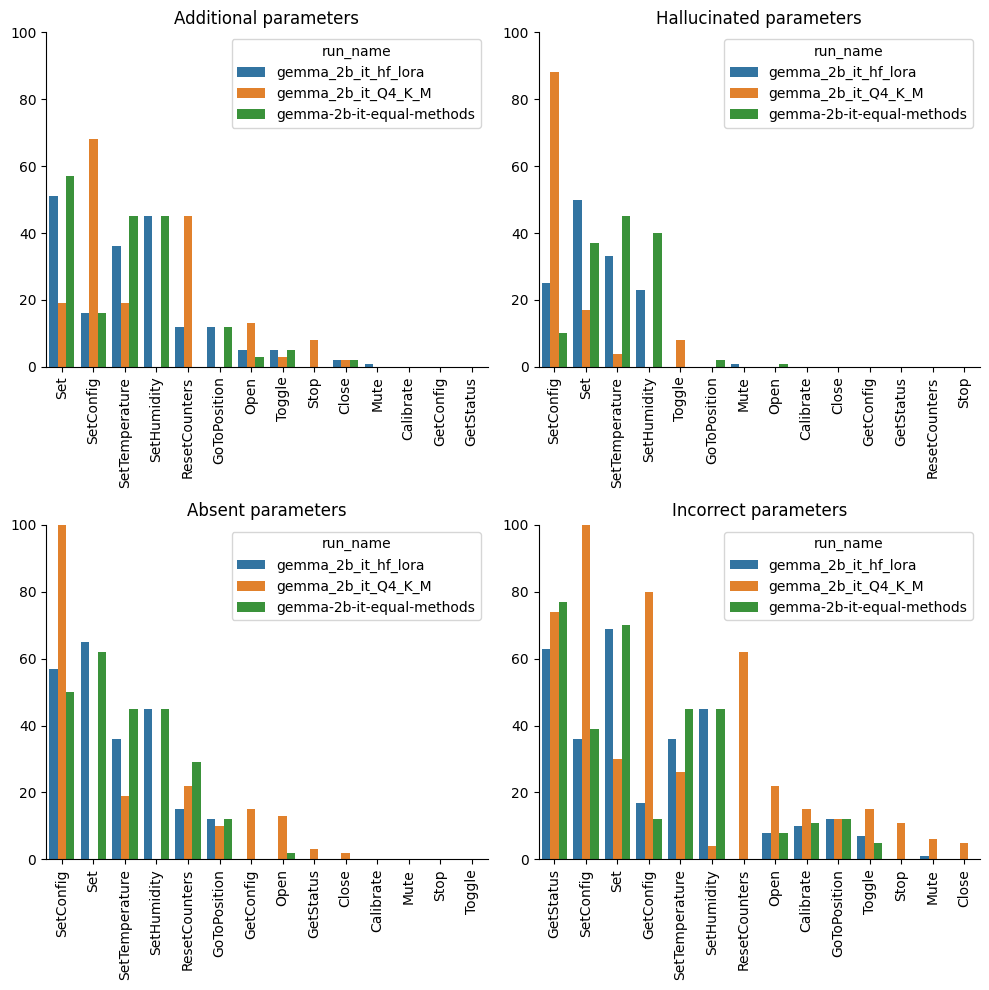

In [102]:
plot_fail_reasons(['gemma_2b_it_hf_lora', 'gemma-2b-it-equal-methods', 'gemma_2b_it_Q4_K_M'])

In [ ]:
plot_fail_reasons(['mistral_7b_instruct_v0.2.Q5_K_M', 'gemma_2b_it_hf_lora'])

In [ ]:
plot_fail_reasons(['mistral_7b_instruct_v0.2.Q5_K_M', 'mistral_7b_instruct_v0.2.Q5_K_M_1_example'])

In [91]:
df = pd.read_csv(OUTPUT_DIR / 'gemma_2b_it_hf_lora/compared.csv') # gemma_2b_it_hf gemma_2b_it_Q4_K_M

In [92]:
# df[df['json_cor'] == True].shape[0] / 1619

In [93]:
print('Add')
display(df[df['retriever_cor'] == True].groupby(by='gt_mtd').apply(lambda x: round((x['add'].value_counts()[False] if False in x['add'].value_counts().index else 0) / x.shape[0], 2)).sort_values(ascending=True))
print('Absent')
display(df[df['retriever_cor'] == True].groupby(by='gt_mtd').apply(lambda x: round((x['absent'].value_counts()[False] if False in x['absent'].value_counts().index else 0) / x.shape[0], 2)).sort_values(ascending=True))
print('Incor')
display(df[df['retriever_cor'] == True].groupby(by='gt_mtd').apply(lambda x: round((x['incor'].value_counts()[False] if False in x['incor'].value_counts().index else 0) / x.shape[0], 2)).sort_values(ascending=True))

Add


gt_mtd
Humidity.SetHumidity          0.00
Cover.GoToPosition            0.00
Temperature.SetTemperature    0.20
Light.Set                     0.20
Switch.Set                    0.50
Light.SetConfig               0.65
Light.ResetCounters           0.82
Light.Toggle                  0.89
Cover.Open                    0.89
Input.SetConfig               0.91
Cover.Close                   0.96
Cover.ResetCounters           0.98
Smoke.Mute                    0.98
Smoke.GetConfig               1.00
Smoke.GetStatus               1.00
Smoke.SetConfig               1.00
Temperature.GetStatus         1.00
Switch.ResetCounters          1.00
Temperature.GetConfig         1.00
Switch.SetConfig              1.00
Switch.Toggle                 1.00
Switch.GetConfig              1.00
Switch.GetStatus              1.00
Cover.Calibrate               1.00
Temperature.SetConfig         1.00
Light.Calibrate               1.00
Input.ResetCounters           1.00
Input.GetStatus               1.00
Input.GetConf

Absent


gt_mtd
Light.Set                     0.00
Humidity.SetHumidity          0.00
Cover.GoToPosition            0.00
Temperature.SetTemperature    0.20
Switch.Set                    0.33
Light.SetConfig               0.35
Input.SetConfig               0.53
Cover.SetConfig               0.63
Light.ResetCounters           0.75
Switch.SetConfig              0.93
Temperature.SetConfig         0.98
Temperature.GetConfig         1.00
Light.Toggle                  1.00
Smoke.GetConfig               1.00
Temperature.GetStatus         1.00
Smoke.Mute                    1.00
Switch.Toggle                 1.00
Smoke.SetConfig               1.00
Switch.GetStatus              1.00
Switch.ResetCounters          1.00
Smoke.GetStatus               1.00
Switch.GetConfig              1.00
Cover.Calibrate               1.00
Light.Calibrate               1.00
Input.ResetCounters           1.00
Input.GetStatus               1.00
Input.GetConfig               1.00
Humidity.SetConfig            1.00
Humidity.GetS

Incor


gt_mtd
Switch.Set                    0.00
Cover.GoToPosition            0.00
Humidity.SetHumidity          0.00
Light.Set                     0.13
Temperature.SetTemperature    0.20
Light.GetStatus               0.46
Input.SetConfig               0.53
Temperature.GetStatus         0.70
Light.SetConfig               0.71
Switch.GetStatus              0.73
Cover.Calibrate               0.78
Switch.GetConfig              0.80
Humidity.GetStatus            0.80
Smoke.GetStatus               0.80
Cover.Open                    0.82
Switch.SetConfig              0.83
Light.GetConfig               0.84
Light.Toggle                  0.84
Input.GetConfig               0.91
Cover.GetStatus               0.94
Input.GetStatus               0.96
Smoke.Mute                    0.98
Cover.Close                   1.00
Temperature.GetConfig         1.00
Switch.Toggle                 1.00
Cover.GetConfig               1.00
Switch.ResetCounters          1.00
Humidity.SetConfig            1.00
Cover.ResetCo

In [45]:
df[['add', 'hall', 'absent', 'incor']].sum()

add       120
hall       49
absent     67
incor     168
dtype: int64

In [99]:
df[(df['retriever_cor'] == True) & (df['incor'] == True) & (df['gt_mtd'] == 'Switch.Set')]

,id,device_name,env,user_cmd,gt_mtd,pred_mtd,gt_json_cmd,pred_json_cmd,retriever_cor,json_cor,add,hall,absent,incor
555,555,Kitchen Switch 1,"Smoke, name=""Garage Smoke 3"", id=75;\nSwitch, name=""Kitchen Switch 1"", id=37;\nInput, name=""Bathroom Input 4"", id=50;\nHumidity, name=""Garage Humidity 3"", id=65;\nSwitch, name=""Bathroom Switch 2"", id=30",Toggle Kitchen Switch 1 after 5 seconds.,Switch.Set,"Switch.Toggle,Switch.Set,Switch.SetConfig","{""method"": ""Switch.Set"", ""params"": {""id"": 37, ""toggle_after"": 5}}","{""method"": ""Switch.Toggle"", ""params"": {""id"": 37, ""toggle_after"": 5}}",True,False,False,True,False,True
556,556,Dining area Switch 3,"Switch, name=""Dining area Switch 3"", id=36;\nLight, name=""Dining area Light 2"", id=75;\nHumidity, name=""Laundry room Humidity 3"", id=32;\nSwitch, name=""Outdoor Switch 2"", id=65;\nLight, name=""Attic Light 4"", id=80",Toggle Dining area Switch 3 after 5 seconds.,Switch.Set,"Switch.Toggle,Switch.Set,Switch.SetConfig","{""method"": ""Switch.Set"", ""params"": {""id"": 36, ""toggle_after"": 5}}","{""method"": ""Switch.Toggle"", ""params"": {""id"": 36}}",True,False,False,False,True,True
557,557,Hallway Switch 4,"Temperature, name=""Basement Temperature 3"", id=41;\nSwitch, name=""Hallway Switch 4"", id=6;\nInput, name=""Basement Input 1"", id=59;\nSwitch, name=""Bedroom Switch 4"", id=4",Toggle Hallway Switch 4 after 5 seconds.,Switch.Set,"Switch.Toggle,Switch.Set,Switch.SetConfig","{""method"": ""Switch.Set"", ""params"": {""id"": 6, ""toggle_after"": 5}}","{""method"": ""Switch.Toggle"", ""params"": {""id"": 6}}",True,False,False,False,True,True
558,558,Outdoor Switch 2,"Light, name=""Closet Light 3"", id=50;\nHumidity, name=""Bathroom Humidity 1"", id=40;\nCover, name=""Patio Cover 3"", id=70;\nSwitch, name=""Outdoor Switch 2"", id=77;\nInput, name=""Living room Input 1"", id=55;\nSwitch, name=""Bedroom Switch 1"", id=33;\nCover, name=""Attic Cover 3"", id=10",Toggle Outdoor Switch 2 after 5 seconds.,Switch.Set,"Switch.Toggle,Switch.Set,Switch.SetConfig","{""method"": ""Switch.Set"", ""params"": {""id"": 77, ""toggle_after"": 5}}","{""method"": ""Switch.Toggle"", ""params"": {""id"": 77, ""toggle_after"": 5}}",True,False,False,True,False,True
559,559,Kitchen Switch 1,"Input, name=""Kitchen Input 2"", id=95;\nInput, name=""Living room Input 1"", id=55;\nInput, name=""Garage Input 4"", id=88;\nHumidity, name=""Living room Humidity 1"", id=63;\nCover, name=""Patio Cover 2"", id=2;\nCover, name=""Living room Cover 2"", id=96;\nSwitch, name=""Kitchen Switch 1"", id=79",Toggle Kitchen Switch 1 after 5 seconds.,Switch.Set,"Switch.Toggle,Switch.Set,Switch.SetConfig","{""method"": ""Switch.Set"", ""params"": {""id"": 79, ""toggle_after"": 5}}","{""method"": ""Switch.Toggle"", ""params"": {""id"": 79, ""toggle_after"": 5}}",True,False,False,True,False,True
560,560,Home office Switch 4,"Cover, name=""Bedroom Cover 4"", id=55;\nSwitch, name=""Home office Switch 4"", id=60;\nLight, name=""Bedroom Light 4"", id=73",Toggle Home office Switch 4 after 5 seconds.,Switch.Set,"Switch.Toggle,Switch.Set,Switch.SetConfig","{""method"": ""Switch.Set"", ""params"": {""id"": 60, ""toggle_after"": 5}}","{""method"": ""Switch.Toggle"", ""params"": {""id"": 60, ""toggle_after"": 5}}",True,False,False,True,False,True
561,561,Home office Switch 3,"Switch, name=""Home office Switch 3"", id=20;\nHumidity, name=""Laundry room Humidity 2"", id=15;\nHumidity, name=""Laundry room Humidity 4"", id=78;\nCover, name=""Patio Cover 1"", id=66",Toggle Home office Switch 3 after 5 seconds.,Switch.Set,"Switch.Toggle,Switch.Set,Switch.SetConfig","{""method"": ""Switch.Set"", ""params"": {""id"": 20, ""toggle_after"": 5}}","{""method"": ""Switch.Toggle"", ""params"": {""id"": 20, ""toggle_after"": 5}}",True,False,False,True,False,True
562,562,Kitchen Switch 3,"Temperature, name=""HVAC room Temperature 1"", id=25;\nLight, name=""Dining area Light 3"", id=58;\nSwitch, name=""Kitchen Switch 3"", id=57;\nSwit

In [53]:
df1 = pd.read_csv(OUTPUT_DIR / 'mistral_7b_instruct_v0.2.Q5_K_M/compared.csv')
df2 = pd.read_csv(OUTPUT_DIR / 'gemma_2b_it_hf_lora/compared.csv')

In [12]:
merged = df1.merge(df2, how='inner', on='id', suffixes=("_mis", "_gem"))

In [17]:
merged[(merged['retriever_cor_mis'] == True) & (merged['retriever_cor_gem'] == False)][['id', 'gt_mtd_mis', 'pred_mtd_mis', 'pred_mtd_gem']].head()

,id,gt_mtd_mis,pred_mtd_mis,pred_mtd_gem
45,45,Humidity.GetStatus,"Humidity.SetHumidity,Humidity.GetStatus,Humidity.GetConfig",Humidity.SetHumidity
46,46,Humidity.GetStatus,"Humidity.SetHumidity,Humidity.GetStatus,Humidity.GetConfig",Humidity.SetHumidity
47,47,Humidity.GetStatus,"Humidity.SetHumidity,Humidity.GetStatus,Humidity.GetConfig",Humidity.SetHumidity
50,50,Humidity.GetStatus,"Humidity.SetHumidity,Humidity.GetStatus,Humidity.GetConfig",Humidity.SetHumidity
51,51,Humidity.GetStatus,"Humidity.SetHumidity,Humidity.GetStatus,Humidity.GetConfig",Humidity.SetHumidity


In [10]:
df[df['retriever_cor'] == True].shape[0] / df.shape[0]

0.9258343634116193

In [30]:
df = pd.read_csv(DATA_DIR / 'datasets/merged/train_0_mtds.csv')
df.groupby('mtd').apply(lambda x: x.shape[0]).sort_values(ascending=False)

mtd
Cover.GetStatus               165
Light.GetStatus               150
Cover.GetConfig               150
Switch.GetStatus              150
Light.SetConfig               150
Humidity.GetStatus            150
Light.ResetCounters           150
Input.GetConfig               150
Input.GetStatus               150
Light.GetConfig               150
Input.SetConfig               135
Temperature.GetStatus         135
Switch.Toggle                 135
Smoke.Mute                    135
Light.Toggle                  135
Cover.Close                   135
Cover.Calibrate               135
Temperature.SetTemperature    135
Cover.ResetCounters           135
Humidity.SetHumidity          135
Cover.Stop                    135
Temperature.SetConfig         120
Cover.Open                    120
Switch.Set                    120
Input.ResetCounters           120
Switch.ResetCounters          120
Cover.GoToPosition            105
Temperature.GetConfig         105
Switch.SetConfig              105
Light.Cali

In [73]:
df = pd.read_csv(DATA_DIR / 'datasets/merged/test_0.csv')
df.groupby('mtd').apply(lambda x: x.shape[0]).sort_values(ascending=False)

mtd
Cover.GetStatus               60
Light.ResetCounters           60
Cover.Calibrate               45
Smoke.Mute                    45
Cover.Close                   45
Light.Set                     45
Light.SetConfig               45
Light.Toggle                  45
Smoke.GetStatus               45
Switch.GetStatus              45
Light.Calibrate               45
Switch.ResetCounters          45
Switch.Toggle                 45
Temperature.GetConfig         45
Temperature.GetStatus         45
Temperature.SetConfig         45
Light.GetConfig               45
Light.GetStatus               45
Input.SetConfig               45
Humidity.GetStatus            45
Cover.GetConfig               45
Cover.Open                    45
Cover.ResetCounters           45
Cover.Stop                    45
Input.ResetCounters           45
Temperature.SetTemperature    45
Humidity.SetConfig            45
Humidity.SetHumidity          45
Input.GetConfig               45
Input.GetStatus               45
Humidi

In [38]:
0.04*df2.shape[0]

64.8

In [52]:
df1[df1['json_cor'] == True].shape[0] / df1.shape[0]

0.7756489493201484

In [51]:
df2[df2['json_cor'] == True].shape[0] / df2.shape[0]

0.7320987654320987

In [57]:
df2['failed'] = (df2['absent'] | df2['incor'] | df2['add'] | df2['hall'])

In [58]:
df2[df2['failed']]

,id,device_name,env,user_cmd,gt_mtd,pred_mtd,gt_json_cmd,pred_json_cmd,retriever_cor,json_cor,add,hall,absent,incor,failed
15,15,Bedroom Light 2,"Humidity, name=""Garage Humidity 1"", id=65;\nLight, name=""Bedroom Light 2"", id=28;\nTemperature, name=""Attic Temperature 2"", id=66;\nHumidity, name=""Attic Humidity 3"", id=54;\nLight, name=""Outdoor Light 4"", id=37;\nSwitch, name=""Bedroom Switch 3"", id=16;\nInput, name=""Attic Input 3"", id=4",Activate Bedroom Light 2 at full brightness.,Light.Set,"Light.Set,Light.SetConfig,Light.GetStatus","{""method"": ""Light.Set"", ""params"": {""id"": 28, ""on"": true, ""brightness"": 100}}","{""method"": ""Light.SetConfig"", ""params"": {""id"": 28, ""config"": {""brightness"": 100}}}",True,False,True,True,True,True,True
16,16,Bedroom Light 1,"Light, name=""Bedroom Light 1"", id=50;\nSwitch, name=""Bedroom Switch 4"", id=1;\nSwitch, name=""Dining area Switch 4"", id=20",Activate Bedroom Light 1 at full brightness.,Light.Set,"Light.Set,Light.GetStatus,Light.SetConfig","{""method"": ""Light.Set"", ""params"": {""id"": 50, ""on"": true, ""brightness"": 100}}","{""method"": ""Light.SetConfig"", ""params"": {""id"": 50, ""config"": {""initial_state"": ""on""}}}",True,False,True,True,True,True,True
17,17,Attic Light 4,"Temperature, name=""Basement Temperature 3"", id=38;\nInput, name=""Kitchen Input 4"", id=78;\nSwitch, name=""Garage Switch 3"", id=73;\nCover, name=""Basement Cover 3"", id=65;\nLight, name=""Attic Light 4"", id=83;\nSmoke, name=""Basement Smoke 4"", id=40;\nInput, name=""Outdoor Input 4"", id=90",Activate Attic Light 4 at full brightness.,Light.Set,"Light.Set,Light.GetStatus,Light.Toggle","{""method"": ""Light.Set"", ""params"": {""id"": 83, ""on"": true, ""brightness"": 100}}","{""method"": ""Light.Set"", ""params"": {""id"": 83, ""output"": true, ""brightness"": 100}}",True,False,False,False,True,False,True
18,18,Bedroom Light 3,"Input, name=""Bedroom Input 4"", id=28;\nCover, name=""Living room Cover 1"", id=32;\nCover, name=""Living room Cover 4"", id=97;\nSmoke, name=""Attic Smoke 4"", id=58;\nLight, name=""Bedroom Light 3"", id=26;\nTemperature, name=""Bedroom Temperature 3"", id=19",Activate Bedroom Light 3 at full brightness.,Light.Set,"Light.Set,Light.GetStatus,Light.Toggle","{""method"": ""Light.Set"", ""params"": {""id"": 26, ""on"": true, ""brightness"": 100}}","{""method"": ""Light.Set"", ""params"": {""id"": 26, ""output"": true, ""brightness"": 100}}",True,False,False,False,True,False,True
19,19,Attic Light 1,"Switch, name=""Bedroom Switch 3"", id=14;\nLight, name=""Attic Light 1"", id=17;\nInput, name=""Bedroom Input 4"", id=84",Activate Attic Light 1 at full brightness.,Light.Set,"Light.Set,Light.GetStatus,Light.Toggle","{""method"": ""Light.Set"", ""params"": {""id"": 17, ""on"": true, ""brightness"": 100}}","{""method"": ""Light.Set"", ""params"": {""id"": 17, ""output"": true, ""brightness"": 100}}",True,False,False,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1614,1614,Basement Light 2,"Humidity, name=""Greenhouse Humidity 2"", id=46;\nSmoke, name=""Hallway Smoke 1"", id=73;\nLight, name=""Basement Light 2"", id=42;\nLight, name=""Study room Light 3"", id=10;\nSwitch, name=""Bedroom Switch 3"", id=45;\nHumidity, name=""Bedroom Humidity 4"", id=22",What is the current brightness level of the Basement Light 2?,Light.GetStatus,"Light.GetStatus,Light.Set,Light.GetConfig","{""method"": ""Light.GetStatus"", ""params"": {""id"": 42}}","{""method"": ""Light.GetConfig"", ""params"": {""id"": 42}}",True,False,False,False,False,True,True
1615,1615,Bathroom Light 4,"Switch, name=""Dining area Switch 4"", id=49;\nHumidity, name=""Laundry room Humidity 4"", id=91;\nSwitch, name=""Garage Switch 1"", id=7;\nHumidity, name=""Plant nursery Humidity 1"", id=38;\nSwitch, name=""Dining area Switch 3"", id=50;\nLight, name=""Bathroom Light 4"", id=26",What is the current brightness level of the Bathroom Light 4?,Light.GetStatus,"Light.

In [62]:
df2[(df2['failed'] == False)].shape[0]

1186

In [64]:
df2[(df2['json_cor'] == True)].shape[0]

1186

In [65]:
df1['failed'] = (df1['absent'] | df1['incor'] | df1['add'] | df1['hall'])

In [69]:
df1[(df1['failed'] == False) & (df1['json_cor'] == False)]

,id,device_name,env,user_cmd,gt_mtd,pred_mtd,gt_json_cmd,pred_json_cmd,retriever_cor,json_cor,add,hall,absent,incor,failed
60,60,Attic Smoke 4,"Smoke, name=""Entryway Smoke 4"", id=86;\nSmoke, name=""Attic Smoke 4"", id=20;\nSwitch, name=""Home office Switch 4"", id=17;\nSwitch, name=""Dining area Switch 3"", id=36",Turn off the alarm on Attic Smoke 4.,Smoke.Mute,"Smoke.Mute,Smoke.GetStatus,Smoke.SetConfig","{""method"": ""Smoke.Mute"", ""params"": {""id"": 20}}","{""method"": ""Smoke.Mute"", ""params"": {""id"": 20, ""mute"": true}}",True,False,False,False,False,False,False
62,62,Attic Smoke 1,"Smoke, name=""Attic Smoke 1"", id=4;\nCover, name=""Garage Cover 2"", id=25;\nLight, name=""Dining area Light 1"", id=55;\nLight, name=""Kitchen Light 4"", id=46",Turn off the alarm on Attic Smoke 1.,Smoke.Mute,"Smoke.Mute,Smoke.GetStatus,Smoke.SetConfig","{""method"": ""Smoke.Mute"", ""params"": {""id"": 4}}","{""method"": ""Smoke.Mute"", ""params"": {""id"": 4, ""mute"": true}}",True,False,False,False,False,False,False
63,63,Garage Smoke 4,"Cover, name=""Attic Cover 3"", id=49;\nSmoke, name=""Hallway Smoke 3"", id=95;\nCover, name=""Bathroom Cover 4"", id=68;\nSmoke, name=""Garage Smoke 4"", id=58;\nLight, name=""Outdoor Light 1"", id=44",Turn off the alarm on Garage Smoke 4.,Smoke.Mute,"Smoke.Mute,Smoke.GetStatus,Switch.Set","{""method"": ""Smoke.Mute"", ""params"": {""id"": 58}}","{""method"": ""Smoke.Mute"", ""params"": {""id"": 58, ""mute"": true}}",True,False,False,False,False,False,False
65,65,Laundry room Smoke 4,"Smoke, name=""Laundry room Smoke 4"", id=31;\nLight, name=""Bathroom Light 2"", id=37;\nSwitch, name=""Garage Switch 4"", id=59;\nLight, name=""Dining area Light 2"", id=85;\nCover, name=""Bathroom Cover 4"", id=94",Turn off the alarm on Laundry room Smoke 4.,Smoke.Mute,"Smoke.Mute,Smoke.GetStatus,Switch.Set","{""method"": ""Smoke.Mute"", ""params"": {""id"": 31}}","{""method"": ""Smoke.Mute"", ""params"": {""id"": 31, ""mute"": true}}",True,False,False,False,False,False,False
66,66,Attic Smoke 2,"Smoke, name=""Kitchen Smoke 2"", id=66;\nHumidity, name=""Kitchen Humidity 2"", id=49;\nLight, name=""Study room Light 3"", id=41;\nSmoke, name=""Attic Smoke 2"", id=5;\nLight, name=""Attic Light 4"", id=90",Turn off the alarm on Attic Smoke 2.,Smoke.Mute,"Smoke.Mute,Smoke.GetStatus,Smoke.SetConfig","{""method"": ""Smoke.Mute"", ""params"": {""id"": 5}}","{""method"": ""Smoke.Mute"", ""params"": {""id"": 5, ""mute"": true}}",True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1536,1538,Bathroom Light 3,"Light, name=""Bathroom Light 3"", id=27;\nSmoke, name=""Bedroom Smoke 1"", id=56;\nSwitch, name=""Living room Switch 2"", id=51","Show me the range map settings for the Bathroom Light 3, please.",Light.GetConfig,"Light.SetConfig,Light.Set","{""method"": ""Light.GetConfig"", ""params"": {""id"": 27}}","{""method"": ""Light.GetConfig"", ""params"": {""id"": 27, ""properties"": [""range_map""]}}",False,False,False,False,False,False,False
1537,1539,Study room Light 1,"Smoke, name=""Attic Smoke 4"", id=48;\nHumidity, name=""Plant nursery Humidity 1"", id=87;\nLight, name=""Study room Light 1"", id=69;\nTemperature, name=""Living room Temperature 4"", id=88;\nLight, name=""Basement Light 3"", id=37","Show me the range map settings for the Study room Light 1, please.",Light.GetConfig,"Light.GetConfig,Light.SetConfig","{""method"": ""Light.GetConfig"", ""params"": {""id"": 69}}","{""method"": ""Light.GetConfig"", ""params"": {""id"": 69, ""properties"": {""range_map"": {""type"": ""array""}}}}",True,False,False,False,False,False,False
1538,1540,Bedroom Light 3,"Smoke, name=""Kitchen Smoke 2"", id=55;\nTemperature, name=""Kitchen Temperature 2"", id=20;\nLight, name=""Bedroom Light 3"", id=82;\nInput, name=""Home office Input 2"", id=98","Show me the range map settings for the Bedroom Light 3, please.",Light.GetConfig,"Light.SetConfig,Light.GetConfig","{""method"": ""Light.GetConfi